In [1]:
import sys
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..')

if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.enums import DataSplit
from src.models.classification.resnet import ResidualBlock, ResNet
from src.utils.config import get_device
from src.trainer import eval_classification, train_classification
from src.models.classification.resnet import BinaryResNetClassifier, MultiResNetClassifier
from src.data.classification import TumorClassificationDataset, TumorBinaryClassificationDataset
from src.utils.visualize import create_classification_results

In [2]:
BATCH_SIZE = 32
DATASET_PATH = os.path.join(src_dir, 'datasets')
# Define the transformation pipeline for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    # Add any other transforms here, e.g., normalization
])

device = get_device()

BINARY_MODEL_PATH = os.path.join(src_dir, 'model_registry', 'tumor_resnetbinaryclassifier.pth')

In [3]:
# Step 1: Prepare the Data
train_dataset = TumorBinaryClassificationDataset(root_dir=DATASET_PATH, split=DataSplit.TRAIN, transform=transform)
test_dataset = TumorBinaryClassificationDataset(root_dir=DATASET_PATH, split=DataSplit.TEST, transform=transform)

# Define data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
model = BinaryResNetClassifier()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# train_classification(model, train_loader, optimizer, criterion, device, n_epochs=10)
# torch.save(model.state_dict(), BINARY_MODEL_PATH)

In [5]:
model = BinaryResNetClassifier()
model.load_state_dict(torch.load(BINARY_MODEL_PATH))

<All keys matched successfully>

In [6]:
# Step 5: Evaluation
# Set the model to evaluation mode. This affects layers like dropout and batchnorm.
model.to(device)
model.eval()

metrics = MetricCollection([BinaryAccuracy()]).to(device)

# Evaluate the model on the test set
with torch.no_grad():
    y_true, y_pred, total_metrics = eval_classification(model, test_loader, criterion, metrics, device, is_multiclass=False)

accuracy = total_metrics['BinaryAccuracy']

# Print the accuracy on the test set
print(f'Accuracy on the test set: {accuracy:.2%}')

  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [00:03<00:00, 10.59it/s]

Accuracy on the test set: 94.74%


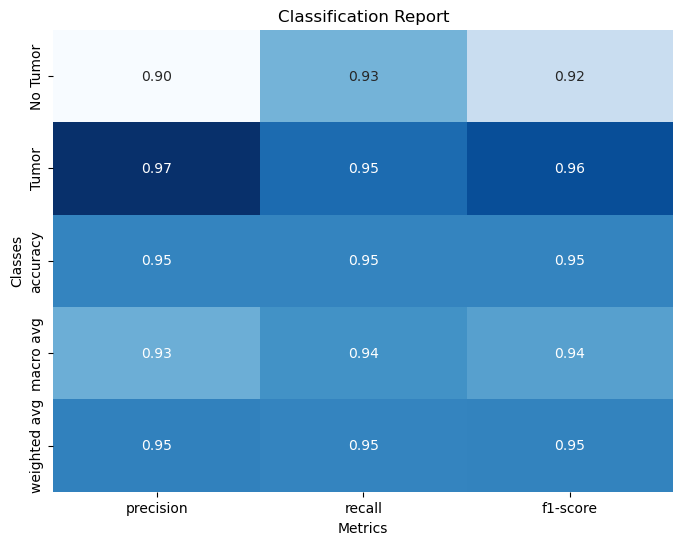

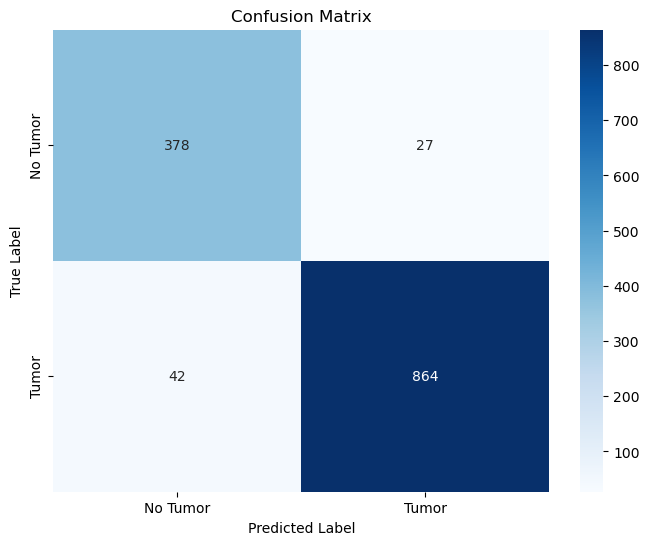

In [7]:
class_names = ['No Tumor', 'Tumor']
create_classification_results(y_true, y_pred, class_names)